In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

%matplotlib inline

### 1. Import Train and Test Data Set

In [43]:
train_df = pd.read_csv('data/train.csv')
train_df['data_set'] = 'train'
train_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


In [44]:
test_df = pd.read_csv('data/test.csv')
test_df['data_set'] = 'test'
test_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,data_set
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,test
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,test
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,test


### 2. Combine both Train and Test Data set (to understand the distribution of independent variable together).

In [45]:
# combine train and test data into one df
all_df = pd.concat([train_df, test_df])
all_df.head(5)

,atemp,casual,count,data_set,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,train,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,train,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,train,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,train,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,train,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


In [46]:
all_df.tail(5)

,atemp,casual,count,data_set,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
6488,12.880,NaN,NaN,test,2012-12-31 19:00:00,0,60,NaN,1,10.66,2,11.0014,1
6489,12.880,NaN,NaN,test,2012-12-31 20:00:00,0,60,NaN,1,10.66,2,11.0014,1
6490,12.880,NaN,NaN,test,2012-12-31 21:00:00,0,60,NaN,1,10.66,1,11.0014,1
6491,13.635,NaN,NaN,test,2012-12-31 22:00:00,0,56,NaN,1,10.66,1,8.9981,1
6492,13.635,NaN,NaN,test,2012-12-31 23:00:00,0,65,NaN,1,10.66,1,8.9981,1


In [47]:
# lowercase column names
all_df.columns = map(str.lower, all_df.columns)
all_df.columns

Index(['atemp', 'casual', 'count', 'data_set', 'datetime', 'holiday',
       'humidity', 'registered', 'season', 'temp', 'weather', 'windspeed',
       'workingday'],
      dtype='object')

In [48]:
# parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(all_df['datetime'])
all_df.set_index(dt, inplace=True)

In [49]:
all_df.head(5)

,atemp,casual,count,data_set,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,14.395,3.0,16.0,train,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
2011-01-01 01:00:00,13.635,8.0,40.0,train,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2011-01-01 02:00:00,13.635,5.0,32.0,train,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
2011-01-01 03:00:00,14.395,3.0,13.0,train,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
2011-01-01 04:00:00,14.395,0.0,1.0,train,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


### 5. Understand the distribution of numerical variables and generate a frequency table for numeric variables.

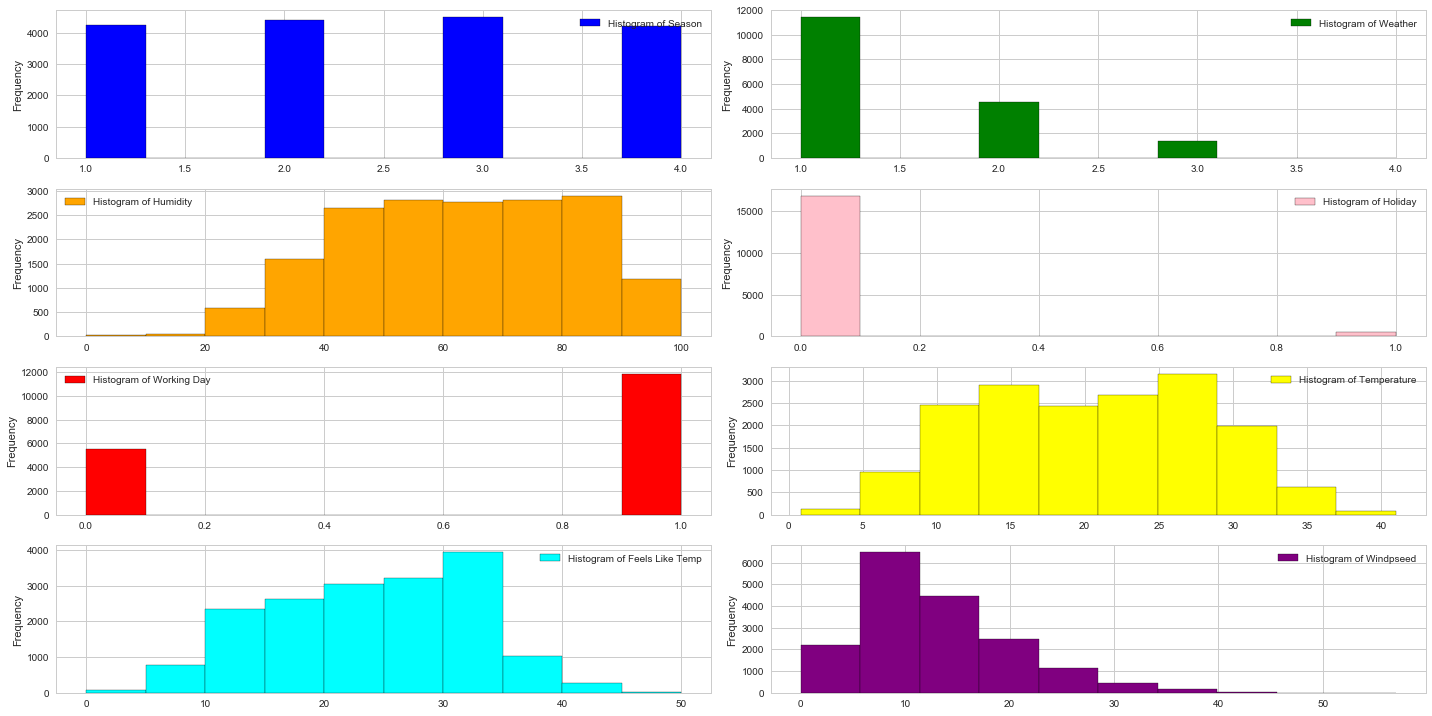

In [50]:
plt.figure(figsize=(20,10))
plt.subplot(421)
all_df['season'].plot.hist(bins=10, color='blue', label='Histogram of Season', edgecolor='black')
plt.legend(loc='best')
plt.subplot(422)
all_df['weather'].plot.hist(bins=10, color='green', label='Histogram of Weather', edgecolor='black')
plt.legend(loc='best')
plt.subplot(423)
all_df['humidity'].plot.hist(bins=10, color='orange', label='Histogram of Humidity', edgecolor='black')
plt.legend(loc='best')
plt.subplot(424)
all_df['holiday'].plot.hist(bins=10, color='pink', label='Histogram of Holiday', edgecolor='black')
plt.legend(loc='best')
plt.subplot(425)
all_df['workingday'].plot.hist(bins=10, color='red', label='Histogram of Working Day', edgecolor='black')
plt.legend(loc='best')
plt.subplot(426)
all_df['temp'].plot.hist(bins=10, color='yellow', label='Histogram of Temperature', edgecolor='black')
plt.legend(loc='best')
plt.subplot(427)
all_df['atemp'].plot.hist(bins=10, color='cyan', label='Histogram of Feels Like Temp', edgecolor='black')
plt.legend(loc='best')
plt.subplot(428)
all_df['windspeed'].plot.hist(bins=10, color='purple', label='Histogram of Windpseed', edgecolor='black')
plt.legend(loc='best')
plt.tight_layout()

Few inferences can be drawn by looking at the these histograms:
- Season has four categories of almost equal distribution
- Weather 1 has higher contribution i.e. mostly clear weather.
- As expected, mostly working days and variable holiday is also showing a similar inference. You can use the code above to look at the distribution in detail. Here you can generate a variable for weekday using holiday and working day. Incase, if both have zero values, then it must be a working day.

In [51]:
all_df['date'] = dt.date
all_df['day'] = dt.day
all_df['month'] = dt.month
all_df['year'] = dt.year
all_df['hour'] = dt.hour
all_df['dow'] = dt.dayofweek
all_df['woy'] = dt.weekofyear

In [52]:
# How many columns have null values
all_df.isnull().sum()

atemp            0
casual        6493
count         6493
data_set         0
datetime         0
holiday          0
humidity         0
registered    6493
season           0
temp             0
weather          0
windspeed        0
workingday       0
date             0
day              0
month            0
year             0
hour             0
dow              0
woy              0
dtype: int64

In [53]:
# interpolate weather, temp, atemp, humidity, windspeed
all_df["weather"] = all_df["weather"].interpolate(method='time').apply(np.round)
all_df["temp"] = all_df["temp"].interpolate(method='time')
all_df["atemp"] = all_df["atemp"].interpolate(method='time')
all_df["humidity"] = all_df["humidity"].interpolate(method='time').apply(np.round)
all_df["windspeed"] = all_df["windspeed"].interpolate(method='time')

In [54]:
by_season = all_df[all_df['data_set'] == 'train'].copy().groupby(['season'])[['count']].agg(sum)

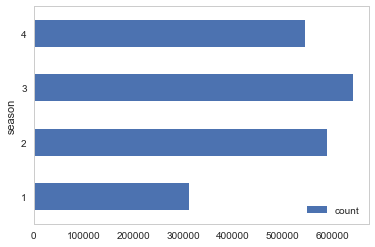

In [55]:
by_season.plot(kind='barh')
plt.grid(False)
plt.show()

In [56]:
by_hour = all_df[all_df['data_set'] == 'train'].copy().groupby(['hour', 'workingday'])['count'].agg('sum').unstack()
by_hour.head(10)

workingday,0,1
hour,,
0,13701.0,11387.0
1,10427.0,4945.0
2,7686.0,2573.0
3,3677.0,1414.0
4,1239.0,1593.0
5,1331.0,7604.0
6,2899.0,31799.0
7,6854.0,90114.0
8,16277.0,148783.0


Hourly trend: There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.

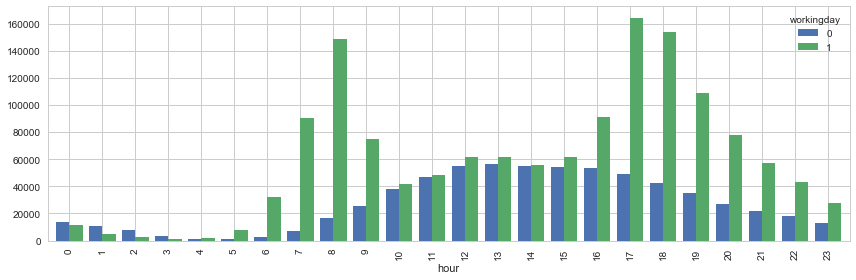

In [57]:
# rentals by hour, split by working day (or not)
by_hour.plot(kind='bar', figsize=(12,4), width=0.8);
plt.grid(True)
plt.tight_layout()

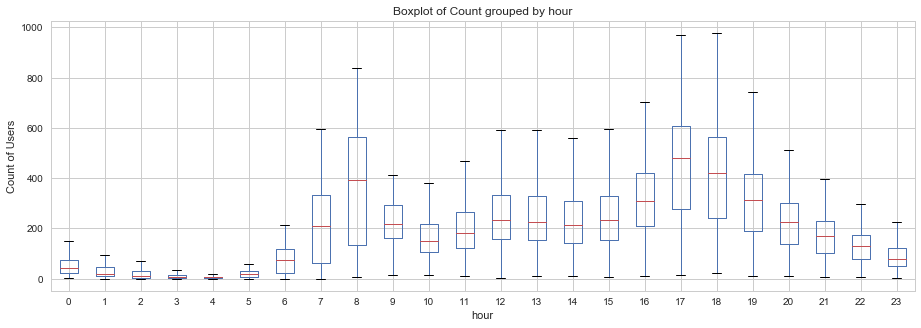

In [58]:
all_df.boxplot(column='count', by='hour', figsize=(15,5))
plt.ylabel('Count of Users')
plt.title("Boxplot of Count grouped by hour")
plt.suptitle("") # get rid of the pandas autogenerated title

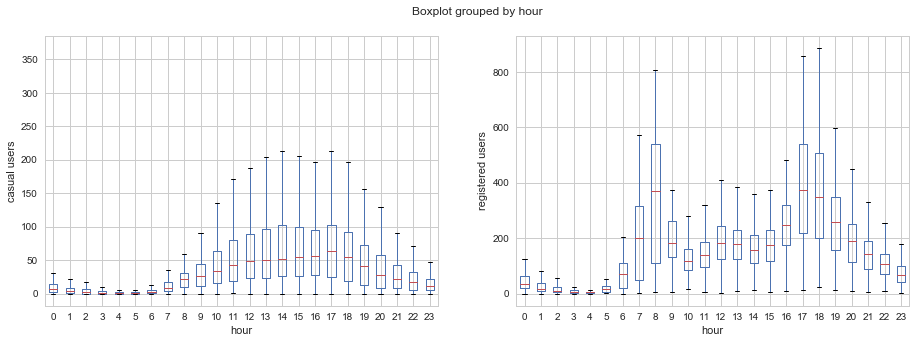

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)

all_df.boxplot(column='casual', by='hour', ax=axs[0])
axs[0].set_ylabel('casual users')
axs[0].set_title('')

all_df.boxplot(column='registered', by='hour', ax=axs[1])
axs[1].set_ylabel('registered users')
axs[1].set_title('')

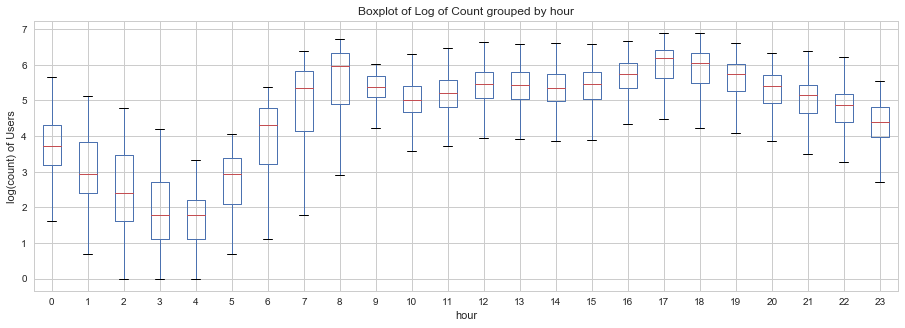

In [60]:
all_df = all_df.assign(log_count = lambda df : np.log(all_df['count']))
all_df.boxplot(column='log_count', by='hour', figsize=(15,5))
plt.ylabel('log(count) of Users')
plt.title("Boxplot of Log of Count grouped by hour")
plt.suptitle("") # get rid of the pandas autogenerated title
all_df.drop(['log_count'], axis = 1, inplace=True)

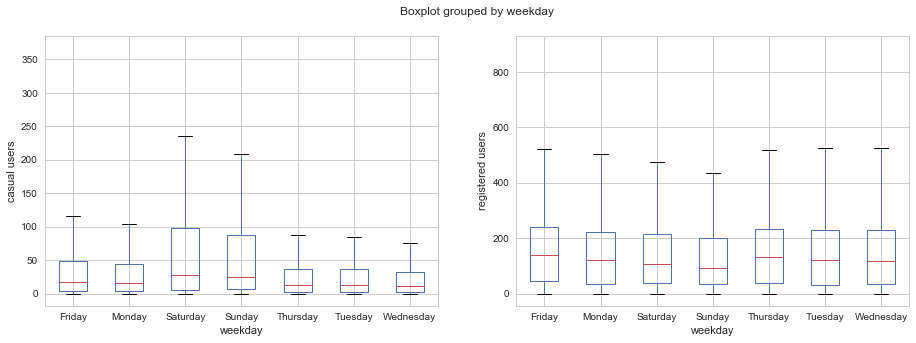

In [61]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
all_df['weekday'] = all_df['dow'].map(dayOfWeek)

fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)

all_df.boxplot(column='casual', by='weekday', ax=axs[0])
axs[0].set_ylabel('casual users')
axs[0].set_title('')

all_df.boxplot(column='registered', by='weekday', ax=axs[1])
axs[1].set_ylabel('registered users')
axs[1].set_title('')

all_df.drop('weekday', axis=1, inplace=True)

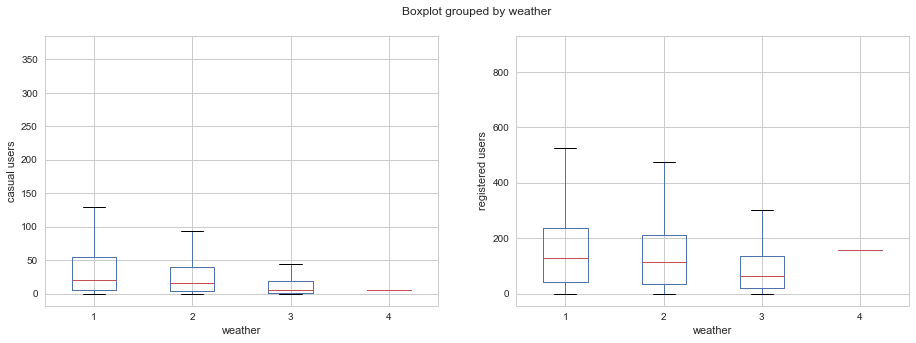

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)

all_df.boxplot(column='casual', by='weather', ax=axs[0])
axs[0].set_ylabel('casual users')
axs[0].set_title('')

all_df.boxplot(column='registered', by='weather', ax=axs[1])
axs[1].set_ylabel('registered users')
axs[1].set_title('')

In [63]:
sub_df = all_df[all_df['data_set'] == 'train'][['registered', 'casual', 'count' ,'temp', 'humidity', 'atemp', 'windspeed']]
sub_df.corr()

,registered,casual,count,temp,humidity,atemp,windspeed
registered,1.000000,0.497250,0.970948,0.318571,-0.265458,0.314635,0.091052
casual,0.497250,1.000000,0.690414,0.467097,-0.348187,0.462067,0.092276
count,0.970948,0.690414,1.000000,0.394454,-0.317371,0.389784,0.101369
temp,0.318571,0.467097,0.394454,1.000000,-0.064949,0.984948,-0.017852
humidity,-0.265458,-0.348187,-0.317371,-0.064949,1.000000,-0.043536,-0.318607
atemp,0.314635,0.462067,0.389784,0.984948,-0.043536,1.000000,-0.057473
windspeed,0.091052,0.092276,0.101369,-0.017852,-0.318607,-0.057473,1.000000


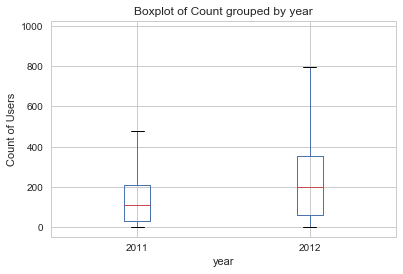

In [64]:
all_df.boxplot(column='count', by='year')
plt.ylabel('Count of Users')
plt.title("Boxplot of Count grouped by year")
plt.suptitle("") # get rid of the pandas autogenerated title

In [65]:
# feature engineer a new column whether its a peak hour or not
all_df['peak'] = all_df[['hour', 'workingday']]\
    .apply(lambda df: 1 if ((df['workingday'] == 1 and (df['hour'] == 8 or 17 <= df['hour'] <= 18)) \
                            or (df['workingday'] == 0 and 10 <= df['workingday'] <= 19)) else 0, axis = 1)

In [66]:
# sandy
all_df['holiday'] = all_df[['month', 'day', 'holiday', 'year']]\
    .apply(lambda df: 1 if (df['year'] == 2012 and df['month'] == 10 and (df['day'] in [30])) else 0, axis = 1)

# christmas and others
all_df['holiday'] = all_df[['month', 'day', 'holiday']]\
    .apply(lambda df: 1 if (df['month'] == 12 and df['day'] in [24, 26, 31]) else df['holiday'], axis = 1)
all_df['workingday'] = all_df[['month', 'day', 'workingday']]\
    .apply(lambda df: 0 if df['month'] == 12 and df['day'] in [24, 31] else df['workingday'], axis = 1)

In [67]:
# from histogram
all_df['ideal'] = all_df[['temp', 'windspeed']]\
    .apply(lambda df: 1 if (df['temp'] > 27 and df['windspeed'] < 30) else 0, axis = 1)
    
all_df['sticky'] = all_df[['humidity', 'workingday']]\
    .apply(lambda df: 1 if (df['workingday'] == 1 and df['humidity'] >= 60) else 0, axis = 1)